<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span><ul class="toc-item"><li><span><a href="#Load-the-data-into-a-dataframe" data-toc-modified-id="Load-the-data-into-a-dataframe-1.1">Load the data into a dataframe</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-2">Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Making-a-copy-of-latuda-df" data-toc-modified-id="Making-a-copy-of-latuda-df-2.1">Making a copy of latuda df</a></span></li></ul></li><li><span><a href="#Sentiment-Analysis-using-textblob-Polarity" data-toc-modified-id="Sentiment-Analysis-using-textblob-Polarity-3">Sentiment Analysis using textblob Polarity</a></span></li><li><span><a href="#Sentiment-Analysis-using-a-logistic-regression-classifier" data-toc-modified-id="Sentiment-Analysis-using-a-logistic-regression-classifier-4">Sentiment Analysis using a logistic regression classifier</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Tasks" data-toc-modified-id="Tasks-4.0.1">Tasks</a></span></li></ul></li><li><span><a href="#Sentiment-Analysis-using-Deep-Learning" data-toc-modified-id="Sentiment-Analysis-using-Deep-Learning-4.1">Sentiment Analysis using Deep Learning</a></span></li><li><span><a href="#This-is-the-deep-learning-code" data-toc-modified-id="This-is-the-deep-learning-code-4.2">This is the deep learning code</a></span></li></ul></li></ul></div>

## Objective

Can we create a model that will accurately assess the sentiment of incoming review comments.  This assumes we will not have a rating column.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

### Load the data into a dataframe

In [2]:
import pandas as pd

In [3]:
latuda = pd.read_csv('https://raw.githubusercontent.com/jimcody2014/nlp_cdc/main/data/latuda.csv')

In [4]:
latuda.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'], dtype='object')

In [5]:
latuda.head()

,drugName,condition,review,rating,date,usefulCount
0,Latuda,Bipolar Disorde,"""I have had great experience so far with Latud...",8,20-Feb-12,39
1,Latuda,Bipolar Disorde,"""I've taken a lot of medications. I was prescr...",3,28-Oct-16,25
2,Latuda,Bipolar Disorde,"""I was deeply suicidal for 15 years with repet...",9,25-Dec-15,33
3,Latuda,Bipolar Disorde,"""I have been taking Latuda 80 mg for 8 months ...",3,23-Apr-13,34
4,Latuda,Schizophrenia,"""We've heard of the Latuda 20-40 mg restlessne...",9,5-Feb-16,15


## Pre-processing

In [6]:
!pip install contractions

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import contractions
import string
import re
from textblob import TextBlob, Word

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


[nltk_data] Downloading package punkt to /Users/jimcody/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jimcody/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/jimcody/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jimcody/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Add a column 'target' based on the rating column
latuda['eval'] = latuda['rating'].apply(lambda x: 'Good' if x >= 6 else 'Bad')
#drop_columns = {'drugName', 'condition','date', 'usefulCount', 'rating'}
#latuda = latuda.drop(columns = drop_columns)
latuda['remove_ctr'] = latuda['review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
# change no_contract back to a string
latuda["review_new"] = [' '.join(map(str, l)) for l in latuda['remove_ctr']]
latuda['tokenized'] = latuda['review_new'].apply(word_tokenize)
latuda['lower'] = latuda['tokenized'].apply(lambda x: [word.lower() for word in x])
punc = string.punctuation
latuda['lower'] = latuda['lower'].apply(lambda x: [word for word in x if word not in punc])

In [8]:
# This is the code that modifies 'review'.  Review is used in the models below.
def clean_text_round1(text):  
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

latuda.review = pd.DataFrame(latuda.review.apply(round1))

In [9]:
stop_words = set(stopwords.words('english'))
latuda['no_stopwords'] = latuda['lower'].apply(lambda x: [word for word in x if word not in stop_words])
latuda['pos_tags'] = latuda['no_stopwords'].apply(nltk.tag.pos_tag)


In [10]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
latuda['wordnet_pos'] = latuda['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
latuda['lemmatized'] = latuda['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

### Making a copy of latuda df

In [12]:
drop_columns = {'remove_ctr', 'review_new', 'tokenized', 'lower','no_stopwords','pos_tags','wordnet_pos'}
latuda2 = latuda.drop(columns = drop_columns)

## Sentiment Analysis using textblob Polarity

In [13]:
sample = latuda.review.sample(1).iloc[0]
print(sample)

 been taking  of latuda for two days now i take it in the morning with breakfast so i  experienced nausea however i do have more difficulty getting up in the morning but once  up i seem to be more energetic than i have been in ages last night i was watching a comedy show on television and laughed so hard for so long it actually scared me like it was completely foreign to me to be express that level of happinessgiddiness on the flip side  noticed that  gained  pounds in two days so that is totally freaking me out i have always been a little overweight so the idea of gaining more weight is untenable for me i will be watching my weight over the next few days and see how it goes


In [14]:
TextBlob(sample).sentiment

Sentiment(polarity=0.1763888888888889, subjectivity=0.3788888888888889)

In [15]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

latuda2['polarity'] = latuda2['review'].apply(pol)
latuda2['subjectivity'] = latuda2['review'].apply(sub)

In [16]:
latuda2.head()

,drugName,condition,review,rating,date,usefulCount,eval,lemmatized,polarity,subjectivity
0,Latuda,Bipolar Disorde,i have had great experience so far with latuda...,8,20-Feb-12,39,Good,"[``, great, experience, far, latuda, start, ta...",0.170000,0.768462
1,Latuda,Bipolar Disorde,ive taken a lot of medications i was prescribe...,3,28-Oct-16,25,Bad,"[``, take, lot, medication, prescribe, latuda,...",0.377222,0.534444
2,Latuda,Bipolar Disorde,i was deeply suicidal for years with repetiti...,9,25-Dec-15,33,Good,"[``, deeply, suicidal, 15, year, repetitive, s...",-0.040427,0.383730
3,Latuda,Bipolar Disorde,i have been taking latuda mg for months and ...,3,23-Apr-13,34,Bad,"[``, take, latuda, 80, mg, 8, month, medicatio...",0.185119,0.656746
4,Latuda,Schizophrenia,weve heard of the latuda mg restlessnesssense...,9,5-Feb-16,15,Good,"[``, heard, latuda, 20-40, mg, restlessness/se...",0.175000,0.487500


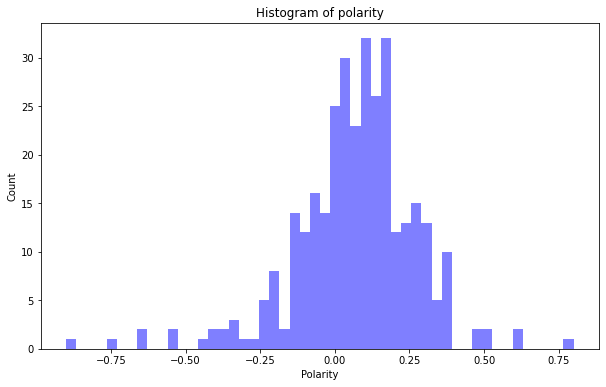

In [17]:
# A histogram of the polarity scores.
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(latuda2.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

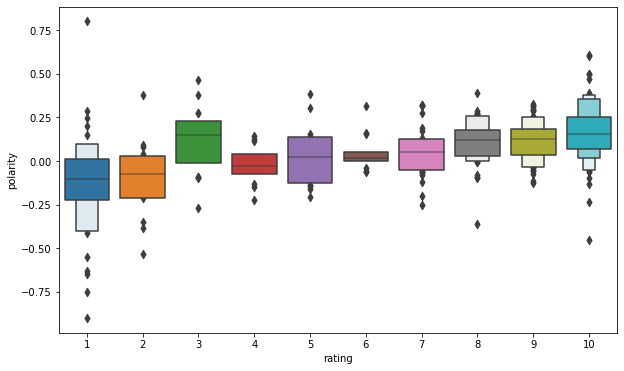

In [18]:
# Box plot of sentiment grouped by rating
plt.figure(figsize=(10,6))
sns.boxenplot(x='rating', y='polarity', data=latuda2)
plt.show();

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

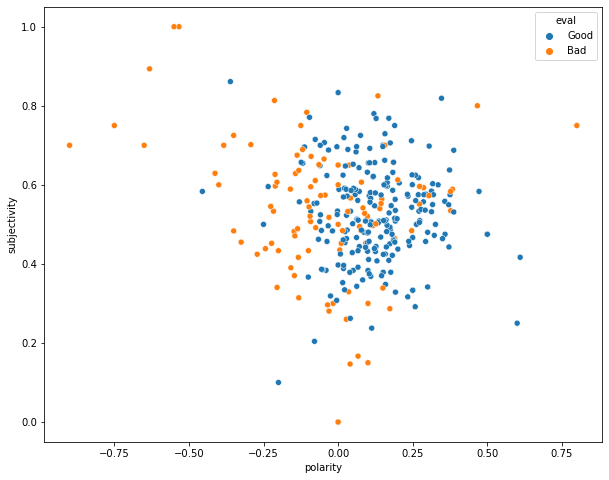

In [19]:
plt.rcParams['figure.figsize'] = [10, 8]
sns.scatterplot(data = latuda2, x = 'polarity', y='subjectivity', hue = 'eval')
    

In [20]:
pd.set_option('max_colwidth', 400)

In [21]:
latuda2[latuda2.polarity == -1].review.head()

Series([], Name: review, dtype: object)

In [22]:
latuda2[latuda2.rating == 1].review.head()

10    before i took latuda my bipolar disorder was pretty much ruining my life i started latuda and about  months later while i was starting to feel so much better i also noticed that i was starting to feel overwhelmed and was starting to become delusional and developed irrational fears such as being scared to even go outside for example i stopped latuda and went back to feeling normal i thought it ...
11                                                                                                                                                                                                                                                                              i was on  of latuda gained  overnight and developed tardive dyskinesia\r\rfor me the side effects outweighed the therapeutic benefits
27                latuda  even come close to touching my bipolar depression i kept waiting and waiting for it to work but nothing happened i ended up having a horrible depressive episode t

In [23]:
latuda2[(latuda2.rating == 5) & (latuda2.polarity <= -0.2)].head(10)

,drugName,condition,review,rating,date,usefulCount,eval,lemmatized,polarity,subjectivity
251,Latuda,Bipolar Disorde,i have taken this med twice in the past few years because of ect i remember my prior experience but for some reason i was taken off it i remember now i experience crippling nausea and irritability i makes me mean also within minutes of taking it so sick i have to lie down going to ask my psychiatrist to take me off it i just function with so much nausea,5,26-Jul-15,22,Bad,"[``, take, med, twice, past, year, ect, 039, remember, prior, experience, reason, take, remember, experience, cripple, nausea, irritability, make, mean, also, within, 15, minute, take, 039, sick, lie, 039, go, ask, psychiatrist, take, 039, function, much, nausea, ``]",-0.20462,0.340505


In [24]:
latuda2[(latuda2.rating == 1) & (latuda2.polarity >= 0.5)].head(10)

,drugName,condition,review,rating,date,usefulCount,eval,lemmatized,polarity,subjectivity
131,Latuda,Bipolar Disorde,i had been on latuda for two months great medicine except i had severe muscle weakness,1,29-Nov-11,38,Bad,"[``, latuda, two, month, great, medicine, except, severe, muscle, weakness, '']",0.8,0.75


Is it possible that the words used in medical reviews are too ambiguous for most common lexicons?

## Sentiment Analysis using a logistic regression classifier

#### Tasks
 - Change Good/Bad to 1/-1 (We've already classified the review as good or bad)
 - visualize counts for 1/-1
 - Reduce columns to review and eval
 - split the datset to train & test
 - create a bag of words
 - import the logistic regression from sklearn
 - fit the model
 - make a prediction
 - determine accuracy
 

In [25]:
latuda.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount',
       'eval', 'remove_ctr', 'review_new', 'tokenized', 'lower',
       'no_stopwords', 'pos_tags', 'wordnet_pos', 'lemmatized'],
      dtype='object')

In [26]:
latuda3 = latuda

# ####### Change to the code

latuda3['eval'] = latuda['rating'].apply(lambda x: 1 if x >= 6 else 0)




drop_columns = {'drugName', 'condition', 'rating', 'date', 'usefulCount', 'remove_ctr', 'review_new', 'tokenized', 'lower',
       'no_stopwords', 'pos_tags', 'wordnet_pos', 'lemmatized'}
latuda3 = latuda3.drop(columns = drop_columns)
latuda3.head()

,review,eval
0,i have had great experience so far with latuda i started taking mg in nov and it worked great for about a week then i crashed again dr put it up to mg and been great ever since afraid though because my sex drive has completely disappeared and if the latuda going to have to go off itand i hate to go off something working so well however also on a pretty high dose of lexapro and the dr t...,1
1,ive taken a lot of medications i was prescribed latuda and it wasnt a very good experience i even sit down to watch a movie without feeling jittery and needing to be on the go when it was bed time my legs were so restless i sleep i would lay in bed kicking my legs non stop never take this again,0
2,i was deeply suicidal for years with repetitive suicidal thoughts on a daily basis i was at the end of my rope close to killing myself and my doctor suggested latuda i started at mg a day at bed time suicidal thoughts and constant thoughts of my year old cat constantly dying largely diminished i have a down episode once every days about where i am hopeless and negative thinking again but ...,1
3,i have been taking latuda mg for months and am on no other medications for medication induced bipolar disorder which was caused by antidepressants prescribed for anxiety latuda should be taken with calories but when i took the medicine with food i was completely engulfed in anxiety within an hour now i take it at night with no food i sleep for hours at night and feel pretty good but am ...,0
4,weve heard of the latuda mg restlessnesssense of muscle quiver being controlled by a small benztropine daily dosage taken with the latuda both were taken in evening as it seemed to help with sleep i believe benztropine may normally be given for parkinson this was suggested by an experienced psychiatrist who reviewed medications looking for one that had the side effect to address and to help...,1


In [27]:
latuda3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  330 non-null    object
 1   eval    330 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [28]:
# random split train and test data
index = latuda3.index
latuda3['random_number'] = np.random.randn(len(index))  # This is just a sample technique
train = latuda3[latuda3['random_number'] <= 0.8]
test = latuda3[latuda3['random_number'] > 0.8]

# X_train, X_test, y_train, y_test = train_test_split(df['abc'], df['xyz'], test_size=0.2, random_state=8)

In [29]:
# Create a 'bag of words' and transform it to a doc matrix.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')     
train_matrix = vectorizer.fit_transform(train['review'])
test_matrix = vectorizer.transform(test['review'])


# token_patternstr, default=r”(?u)\b\w\w+\b”
# Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'. 
# The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely 
# ignored and always treated as a token separator).


# fit_transform() is used on the training data so that we can scale the training data 
# and also learn the scaling parameters of that data.
# The fit method is calculating the mean and variance of each of the features present in our data. 
# The transform method is transforming all the features using the respective mean and variance.

"token_patternstr, default=r”(?u)\x08\\w\\w+\x08”\nRegular expression denoting what constitutes a “token”, only used if analyzer == 'word'. \nThe default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely \nignored and always treated as a token separator).\n\n\nfit_transform() is used on the training data so that we can scale the training data \nand also learn the scaling parameters of that data.\nThe fit method is calculating the mean and variance of each of the features present in our data. \nThe transform method is transforming all the features using the respective mean and variance."

In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr = LogisticRegression()

In [31]:
# X is the independent variable, Y is the target

X_train = train_matrix
X_test = test_matrix
y_train = train['eval']
y_test = test['eval']

In [32]:
lr.fit(X_train,y_train)    # Run a logistic regression on the training data

LogisticRegression()

In [33]:
predictions = lr.predict(X_test)

In [34]:
# A confusion matrix is used to evaluate the performance of a classification model
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[12,  5],
       [ 9, 40]])

 - Rows are predicted, columns are actual.  
 - Top left (pos,pos). True Positive. These are correctly predicted.
 - Bottom right (neg,neg). True Negative. These are correctly predicted.
 - bottom left (false negative), top right (false positive) are the number of incorrect predictions

In [35]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))


# Accuracy: Accuracy assesses whether a series of measurements are correct on average.
# Precision: Precision indicates how close the measurements are to each other.
# Recall: Number of true positives divided by the number of true positives plus the number of false negatives.

Accuracy: 0.7878787878787878
Precision: 0.8163265306122449
Recall: 0.8888888888888888


### Sentiment Analysis using Deep Learning

In [36]:
latuda3.head()

,review,eval,random_number
0,i have had great experience so far with latuda i started taking mg in nov and it worked great for about a week then i crashed again dr put it up to mg and been great ever since afraid though because my sex drive has completely disappeared and if the latuda going to have to go off itand i hate to go off something working so well however also on a pretty high dose of lexapro and the dr t...,1,0.356318
1,ive taken a lot of medications i was prescribed latuda and it wasnt a very good experience i even sit down to watch a movie without feeling jittery and needing to be on the go when it was bed time my legs were so restless i sleep i would lay in bed kicking my legs non stop never take this again,0,-0.417830
2,i was deeply suicidal for years with repetitive suicidal thoughts on a daily basis i was at the end of my rope close to killing myself and my doctor suggested latuda i started at mg a day at bed time suicidal thoughts and constant thoughts of my year old cat constantly dying largely diminished i have a down episode once every days about where i am hopeless and negative thinking again but ...,1,0.822047
3,i have been taking latuda mg for months and am on no other medications for medication induced bipolar disorder which was caused by antidepressants prescribed for anxiety latuda should be taken with calories but when i took the medicine with food i was completely engulfed in anxiety within an hour now i take it at night with no food i sleep for hours at night and feel pretty good but am ...,0,0.515142
4,weve heard of the latuda mg restlessnesssense of muscle quiver being controlled by a small benztropine daily dosage taken with the latuda both were taken in evening as it seemed to help with sleep i believe benztropine may normally be given for parkinson this was suggested by an experienced psychiatrist who reviewed medications looking for one that had the side effect to address and to help...,1,-1.177717


In [37]:
latuda3.drop('random_number', axis=1, inplace=True)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X=latuda3['review'].values

In [40]:
Y=latuda3['eval'].values

/opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='eval', ylabel='count'>

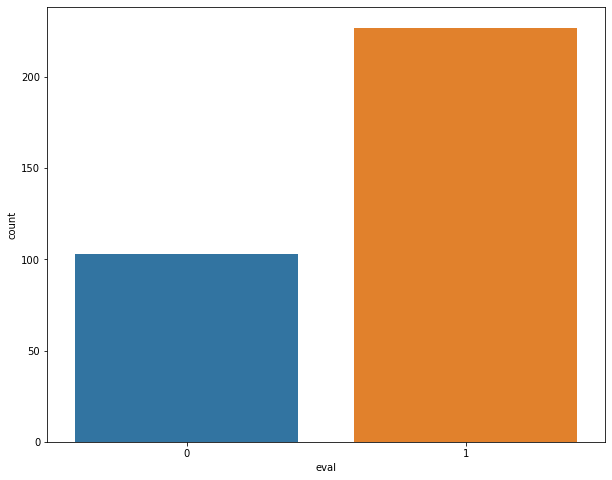

In [41]:
import seaborn as sns
sns.countplot(latuda3['eval'])

In [42]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.3)

In [43]:
vec = CountVectorizer()
vec

CountVectorizer()

In [44]:
vec.fit(X_train)

CountVectorizer()

In [45]:
x_train=vec.transform(X_train)

In [46]:
x_test=vec.transform(X_test)

In [47]:
x_train

<231x2294 sparse matrix of type '<class 'numpy.int64'>'
	with 13787 stored elements in Compressed Sparse Row format>

### This is the deep learning code

 - An activation function is a function that is added into an artificial neural network in order to help the network learn complex patterns in the data. 
 
 - https://www.tensorflow.org/tutorials/keras/classification

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(16, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

2021-12-09 11:55:27.811677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                36720     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 37,009
Trainable params: 37,009
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(x_train, Y_train,epochs=100,verbose=True,batch_size=16)

Epoch 1/100
15/15 [==============================] - 0s 913us/step - loss: 0.7201 - accuracy: 0.5050
Epoch 2/100
15/15 [==============================] - 0s 937us/step - loss: 0.5964 - accuracy: 0.7359
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5123 - accuracy: 0.7185
Epoch 4/100
 1/15 [=>............................] - ETA: 0s - loss: 0.3333 - accuracy: 0.9375

2021-12-09 11:55:28.190933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


15/15 [==============================] - 0s 1ms/step - loss: 0.3728 - accuracy: 0.8451
Epoch 5/100
15/15 [==============================] - 0s 930us/step - loss: 0.3096 - accuracy: 0.9160
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1954 - accuracy: 0.9621
Epoch 7/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1425 - accuracy: 0.9807
Epoch 8/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0854 - accuracy: 0.9907
Epoch 9/100
15/15 [==============================] - 0s 968us/step - loss: 0.0510 - accuracy: 1.0000
Epoch 10/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0414 - accuracy: 1.0000
Epoch 11/100
15/15 [==============================] - 0s 865us/step - loss: 0.0363 - accuracy: 1.0000
Epoch 12/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0271 - accuracy: 1.0000
Epoch 13/100
15/15 [==============================] - 0s 812us/step - loss: 0.0218 - accuracy: 1.0000
Epoch 14/1

15/15 [==============================] - 0s 822us/step - loss: 1.8428e-04 - accuracy: 1.0000
Epoch 84/100
15/15 [==============================] - 0s 666us/step - loss: 2.9973e-04 - accuracy: 1.0000
Epoch 85/100
15/15 [==============================] - 0s 954us/step - loss: 3.4096e-04 - accuracy: 1.0000
Epoch 86/100
15/15 [==============================] - 0s 699us/step - loss: 2.7453e-04 - accuracy: 1.0000
Epoch 87/100
15/15 [==============================] - 0s 878us/step - loss: 2.4394e-04 - accuracy: 1.0000
Epoch 88/100
15/15 [==============================] - 0s 939us/step - loss: 2.2230e-04 - accuracy: 1.0000
Epoch 89/100
15/15 [==============================] - 0s 741us/step - loss: 4.0810e-04 - accuracy: 1.0000
Epoch 90/100
15/15 [==============================] - 0s 1ms/step - loss: 2.9237e-04 - accuracy: 1.0000
Epoch 91/100
15/15 [==============================] - 0s 688us/step - loss: 1.7218e-04 - accuracy: 1.0000
Epoch 92/100
15/15 [==============================] - 0s 689u

In [51]:
model.evaluate(x_train,Y_train)

8/8 [==============================] - 0s 737us/step - loss: 2.1104e-04 - accuracy: 1.0000


[0.00021103725885041058, 1.0]

In [52]:
model.evaluate(x_test,Y_test)

4/4 [==============================] - 0s 755us/step - loss: 0.7744 - accuracy: 0.7778


[0.7743812203407288, 0.7777777910232544]

In [53]:
model.metrics_names

# Loss is a value that represents the summation of errors in our model. 
# Accuracy is more straightforward. It measures how well our model predicts by comparing the model 
#     predictions with the true values in terms of percentage.

['loss', 'accuracy']

In [54]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

model.predict(examples)

ValueError: in user code:

    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1473 predict_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1463 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1456 run_step  **
        outputs = model.predict_step(data)
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1429 predict_step
        return self(x, training=False)
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/envs/NLP_code/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 2294 but received input with shape (None, 1)
